## Instructions

In this lab you'll be doing a bit more of a comprehensive analysis. Despite coming from Kaggle, this will not be a competition. Check out the data source and context here:

https://www.kaggle.com/datasets/riinuanslan/sleep-data-from-fitbit-trackerLinks to an external site.

It's a relatively simple dataset, but your goal is this: 

Can we predict Sleep Score (posted by the FitBit app) using the other metrics in the dataset? In other words, is there a formula here that the FitBit app uses to compute Sleep Score that we can reverse-engineer?
Two constraints for this assignment:

1. Your modeling efforts must involve bagging and stacking in some way. Otherwise, you may try whatever you like.

2. You are allowed, even encouraged, to compute and/or gather additional features to use as explanatory variables in your model. For example, you might create a variable for the time they went to sleep (as a measure of how "early" they went to bed, or not). There are multiple datasets and you should use all of them, which means you may use the corresponding month for the dataset as a variable as well (or anything related to it).

Your submission should be an HTML or .ipynb file of all of your work.

## Data Cleaning and Preparation

After some quick examination, I noticed a few typos that needed to be fixed. 

In [449]:
import pandas as pd

In [450]:
# File paths
file_paths = [
    "Data/November Sleep Data - Sheet1.csv",
    "Data/December Sleep data - Sheet1.csv",
    "Data/January sleep data - Sheet1.csv",
    "Data/February sleep data - Sheet1 (1).csv",
    "Data/March sleep data - Sheet1.csv",
    "Data/April sleep data - Sheet1.csv"
]

# Function to clean each file
def clean_sleep_df(file_path, month_name):
    df = pd.read_csv(file_path)

    # Drop first row if mostly empty
    if df.iloc[0].isnull().sum() > len(df.columns) // 2 or (df.iloc[0] == df.columns).sum() > len(df.columns) // 2:
        df = df.iloc[1:]

    # Standardize column names
    df.columns = df.columns.str.replace(month_name.upper(), 'Day of Week', regex=False)
    df.columns = df.columns.str.strip().str.upper()

    # Rename if columns exist
    col_renames = {
        'SLEEP SQORE': 'SLEEP SCORE',
        'HEART RATE UNDER RESTING': 'HEART RATE BELOW RESTING',
        'HEARTRATE BELOW RESTING': 'HEART RATE BELOW RESTING'
    }
    df = df.rename(columns={col: new for col, new in col_renames.items() if col in df.columns})

    return df

# Map of months to file paths, February is special!
month_map = {
    "November": file_paths[0],
    "December": file_paths[1],
    "January": file_paths[2],
    "Febeuary": file_paths[3],
    "March": file_paths[4],
    "April": file_paths[5],
}

# Clean and combine all DataFrames
df_all = pd.concat(
    [clean_sleep_df(path, month) for month, path in month_map.items()],
    ignore_index=True
)

df_all.head()

,DAY OF WEEK,DATE,SLEEP SCORE,HOURS OF SLEEP,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,SLEEP TIME
0,Monday,11/1/2021,88.0,8:06:00,20.00%,13.00%,84.00%,10:41pm - 7:54am
1,Tuesday,11/2/2021,83.0,7:57:00,12.00%,18.00%,90.00%,10:40pm - 7:55am
2,Wednesday,11/3/2021,81.0,7:06:00,13.00%,22.00%,93.00%,11:03pm - 7:16am
3,Thursday,11/4/2021,86.0,7:04:00,19.00%,17.00%,97.00%,10:55pm - 6:56am
4,Friday,11/5/2021,81.0,9:24:00,17.00%,15.00%,66.00%,10:14pm - 9:01am


### Clean up Sleep Time

In [451]:
# Split 'SLEEP TIME' into 'BED TIME' and 'WAKE UP TIME'
df_all[['BED TIME', 'WAKE UP TIME']] = df_all['SLEEP TIME'].astype(str).str.split(' - ', expand=True)
df_all = df_all.drop(columns=['SLEEP TIME'])

# Check rows where values didn't parse cleanly
print(df_all[df_all['WAKE UP TIME'].str.endswith('m') == False])
print(df_all[df_all['BED TIME'].str.endswith('m') == False])

   DAY OF WEEK        DATE  SLEEP SCORE HOURS OF SLEEP REM SLEEP DEEP SLEEP  \
37   Wednesday  12/08/2021         85.0        6:47:00    22.00%     16.00%   
57     Tuesday  12/28/2021         85.0        6:57:00    20.00%     18.00%   

   HEART RATE BELOW RESTING BED TIME WAKE UP TIME  
37                   94.00%  11:40pm         7:33  
57                   99.00%  11:16pm         7:02  
    DAY OF WEEK        DATE  SLEEP SCORE HOURS OF SLEEP REM SLEEP DEEP SLEEP  \
5      Saturday   11/6/2021         77.0        8:19:00    14.00%     13.00%   
125      Sunday  03/06/2022          NaN            NaN       NaN        NaN   
138    Saturday  03/19/2022          NaN            NaN       NaN        NaN   

    HEART RATE BELOW RESTING BED TIME WAKE UP TIME  
5                     21.00%    11:21       8:45am  
125                      NaN      nan         None  
138                      NaN      nan         None  


### Feature Engineering and Further Cleaning

In [452]:
df_all = df_all.dropna(subset=['BED TIME', 'WAKE UP TIME'])
# Add 'pm' to BED TIME if it doesn’t already end in 'am' or 'pm'
df_all['BED TIME'] = df_all['BED TIME'].astype(str)
df_all.loc[~df_all['BED TIME'].str.endswith(('am', 'pm')), 'BED TIME'] += 'pm'

# Add 'am' to WAKE UP TIME if it doesn’t already end in 'am' or 'pm'
df_all['WAKE UP TIME'] = df_all['WAKE UP TIME'].astype(str)
df_all.loc[~df_all['WAKE UP TIME'].str.endswith(('am', 'pm')), 'WAKE UP TIME'] += 'am'

# Fix common typo in both time columns
df_all['BED TIME'] = df_all['BED TIME'].str.replace('-', ':', regex=False)
df_all['WAKE UP TIME'] = df_all['WAKE UP TIME'].str.replace('-', ':', regex=False)

In [453]:
# Fix DATE column and extract components
df_all['DATE'] = pd.to_datetime(df_all['DATE'], errors='coerce')
df_all['YEAR'] = df_all['DATE'].dt.year
df_all['MONTH'] = df_all['DATE'].dt.month
df_all['DAY'] = df_all['DATE'].dt.day
df_all = df_all.drop(columns=['DATE'])

# Convert percentages to decimals
pct_cols = ['REM SLEEP', 'DEEP SLEEP', 'HEART RATE BELOW RESTING']
for col in pct_cols:
    df_all[col] = df_all[col].astype(str).str.replace('%', '', regex=False).astype(float) / 100

# Convert HOURS OF SLEEP (hh:mm:ss) to float hours
def time_to_hours(t):
    try:
        parts = [int(x) for x in str(t).split(':')]
        return parts[0] + parts[1]/60 + (parts[2]/3600 if len(parts) == 3 else 0)
    except:
        return None

df_all['HOURS OF SLEEP'] = df_all['HOURS OF SLEEP'].apply(time_to_hours)

# Categorize times of day
def categorize_time(t):
    try:
        time = pd.to_datetime(t, format="%I:%M%p").time()
        hour = time.hour + time.minute / 60
        if hour < 4:
            return "Late Night"
        elif hour < 8:
            return "Early Morning"
        elif hour < 12:
            return "Morning"
        elif hour < 17:
            return "Afternoon"
        elif hour < 21:
            return "Evening"
        else:
            return "Night"
    except:
        return "Unknown"

df_all['BED TIME CATEGORY'] = df_all['BED TIME'].apply(categorize_time)
df_all['WAKE TIME CATEGORY'] = df_all['WAKE UP TIME'].apply(categorize_time)

def extract_hour_float(t):
    try:
        dt = pd.to_datetime(t, format="%I:%M%p")
        return dt.hour + dt.minute / 60
    except:
        return None

df_all['BED TIME (HOUR)'] = df_all['BED TIME'].apply(extract_hour_float)
df_all['WAKE UP TIME (HOUR)'] = df_all['WAKE UP TIME'].apply(extract_hour_float)

df_all.drop(columns = ['BED TIME', 'WAKE UP TIME'], inplace=True)

In [454]:
df_sleep_clean = df_all.copy()
df_sleep_clean.head()

,DAY OF WEEK,SLEEP SCORE,HOURS OF SLEEP,REM SLEEP,DEEP SLEEP,HEART RATE BELOW RESTING,YEAR,MONTH,DAY,BED TIME CATEGORY,WAKE TIME CATEGORY,BED TIME (HOUR),WAKE UP TIME (HOUR)
0,Monday,88.0,8.100000,0.20,0.13,0.84,2021,11,1,Night,Early Morning,22.683333,7.900000
1,Tuesday,83.0,7.950000,0.12,0.18,0.90,2021,11,2,Night,Early Morning,22.666667,7.916667
2,Wednesday,81.0,7.100000,0.13,0.22,0.93,2021,11,3,Night,Early Morning,23.050000,7.266667
3,Thursday,86.0,7.066667,0.19,0.17,0.97,2021,11,4,Night,Early Morning,22.916667,6.933333
4,Friday,81.0,9.400000,0.17,0.15,0.66,2021,11,5,Night,Morning,22.233333,9.016667


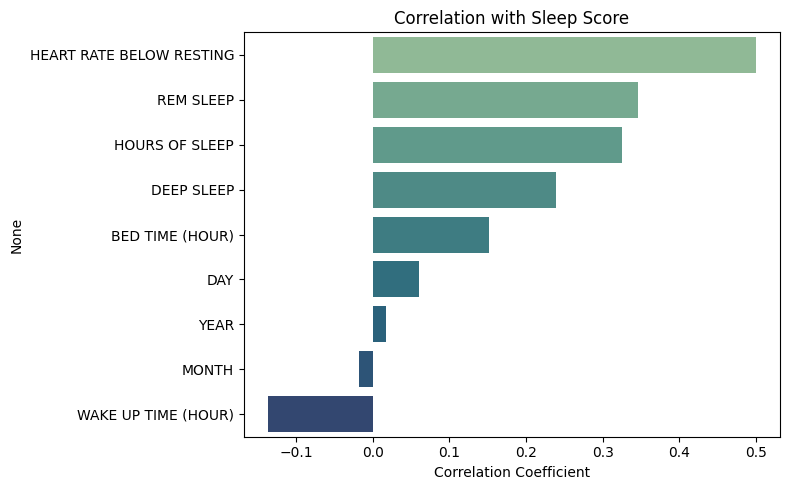

In [455]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlations with Sleep Score
correlations = df_sleep_clean.corr(numeric_only=True)['SLEEP SCORE'].sort_values(ascending=False)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=correlations.values[1:], y=correlations.index[1:], palette="crest", hue = correlations.index[1:])
plt.title("Correlation with Sleep Score")
plt.xlabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

Based on the correlation analysis shown above, the strongest numerical predictors of SLEEP SCORE are:

HEART RATE BELOW RESTING (0.50) – Higher proportions below resting heart rate are associated with higher sleep scores.

REM SLEEP (0.35) – More REM sleep correlates with higher sleep scores.

HOURS OF SLEEP (0.33) – Longer sleep duration has a positive impact.

DEEP SLEEP (0.24) – Also positively associated, though slightly less strongly.

BED TIME (HOUR) (0.15) – Later bedtimes show a weaker positive correlation.

WAKE UP TIME (HOUR) (-0.14) – Slight negative relationship; earlier wake-ups might be beneficial.

### Save to CSV for future use...

In [456]:
df_sleep_clean.to_csv("Data/Cleaned_Sleep_Data.csv", index = False)

## Modeling

Now that our data is cleaned and prepped, we can move onto modeling!

### Bagging Ensemble Models

Based on some trial and error, I found that the best performing features were: 

```
['DAY OF WEEK', 'HOURS OF SLEEP', 'REM SLEEP', 'DEEP SLEEP',
 'HEART RATE BELOW RESTING', 'MONTH', 'YEAR', 'BED TIME CATEGORY', 'WAKE TIME CATEGORY']
```


In [457]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

#### Descision Tree Regressor

In [458]:
# Split predictors and target
X = df_sleep_clean[['DAY OF WEEK', 'HOURS OF SLEEP', 'REM SLEEP', 'DEEP SLEEP', 'HEART RATE BELOW RESTING', 'MONTH', 'YEAR', 'BED TIME CATEGORY', 'WAKE TIME CATEGORY']]
y = df_sleep_clean['SLEEP SCORE']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

# Preprocessing for categorical features
categorical_features = ['DAY OF WEEK', 'BED TIME CATEGORY', 'WAKE TIME CATEGORY']
categorical_transformer = OneHotEncoder(drop='first', handle_unknown = 'ignore')

tree_preprocessor = ColumnTransformer(
    transformers=[('cat', categorical_transformer, categorical_features)],
    remainder='passthrough'
)

# Pipeline: preprocessing + bagging model
pipe_tree = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('regressor', BaggingRegressor(
        estimator=DecisionTreeRegressor(random_state=3),
        random_state=3
    )),
])

# Grid search
param_grid_tree = {
    'regressor__n_estimators': [50, 100, 200, 250], # B 
    'regressor__estimator__max_depth': [None, 5, 10, 20],
    'regressor__estimator__min_samples_split': [2, 5]
}

# Grid search with cross-validation
grid_search = GridSearchCV(pipe_tree, param_grid_tree, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate best model
best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)
print(f"Best Params: {grid_search.best_params_}")
print(f"Bagging MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"Bagging R²: {r2_score(y_test, y_pred):.3f}")

Best Params: {'regressor__estimator__max_depth': None, 'regressor__estimator__min_samples_split': 5, 'regressor__n_estimators': 50}
Bagging MSE: 3.66
Bagging R²: 0.780


#### Ridge Regressor

In [459]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

numeric_transformer = StandardScaler()
numeric_features = [col for col in X.columns if col not in categorical_features]


ridge_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)
pipe_ridge = Pipeline(steps=[
    ('preprocessor', ridge_preprocessor),
    ('regressor', BaggingRegressor(estimator=Ridge(),
        random_state=3
    )),
])

param_grid_ridge = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__estimator__alpha': [0.1, 1.0, 10.0]
}

grid_ridge = GridSearchCV(pipe_ridge, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_ridge.fit(X_train, y_train)

# Evaluate best model
best_ridge = grid_ridge.best_estimator_
y_pred = best_ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred)
ridge_r2 = r2_score(y_test, y_pred)

print(f"Best Params: {grid_ridge.best_params_}")
print(f"Bagging Ridge Test MSE: {ridge_mse:.2f}")
print(f"Bagging Ridge Test R²: {ridge_r2:.3f}")

Best Params: {'regressor__estimator__alpha': 10.0, 'regressor__n_estimators': 200}
Bagging Ridge Test MSE: 4.07
Bagging Ridge Test R²: 0.755


#### SVR

In [460]:
from sklearn.svm import SVR

svr_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numeric_transformer, numeric_features)
    ]
)

# Pipeline
pipe_svr = Pipeline(steps=[
    ('preprocessor', svr_preprocessor),
    ('regressor', BaggingRegressor(
        estimator=SVR(),
        random_state=3
    )),
])

# Grid
param_grid_svr = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__estimator__C': [0.1, 1.0, 10.0]
}

# GridSearch
grid_svr = GridSearchCV(pipe_svr, param_grid_svr, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train, y_train)

# Evaluation
best_svr = grid_svr.best_estimator_
y_pred = best_svr.predict(X_test)
svr_mse = mean_squared_error(y_test, y_pred)
svr_r2 = r2_score(y_test, y_pred)

print(f"Best Params: {grid_svr.best_params_}")
print(f"Bagging (SVR) Test MSE: {svr_mse:.2f}")
print(f"Bagging (SVR) Test R²: {svr_r2:.3f}")


Best Params: {'regressor__estimator__C': 10.0, 'regressor__n_estimators': 200}
Bagging (SVR) Test MSE: 5.26
Bagging (SVR) Test R²: 0.683


#### Random Forest Regressor

In [464]:
from sklearn.ensemble import RandomForestRegressor

pipe_rf = Pipeline(steps=[
    ('preprocessor', tree_preprocessor),
    ('regressor', RandomForestRegressor(random_state=3))
])

# Random Forest hyperparameters
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200, 250],
    'regressor__max_depth': [None, 5, 10, 20],
    'regressor__min_samples_split': [2, 5],
    'regressor__max_features': [None, 'sqrt', 'log2']
}

# Grid search for RF
grid_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_rf.fit(X_train, y_train)

# Evaluate RF
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Best Params: {grid_rf.best_params_}")
print(f"RF Test MSE: {mse_rf:.2f}")
print(f"RF Test R²: {r2_rf:.3f}")

Best Params: {'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 50}
RF Test MSE: 3.68
RF Test R²: 0.778


For the bagging ensemble models, I experimented with several base learners using a consistent set of high-performing features, including measures of sleep duration, sleep stages, heart rate, and time-based variables like month and bedtime category. The Decision Tree and Random Forest regressors performed the best overall, with the bagged Decision Tree achieving an R² of **0.780** and the Random Forest slightly behind at **0.778**. These models benefitted from the ability to handle complex interactions and non-linear relationships in the sleep data.

The bagged Ridge Regressor also performed decently (R² = **0.755**) but showed slightly higher error, likely due to its linear nature and lower flexibility. The SVR-based bagging model had the weakest performance (R² = **0.683**), even with hyperparameter tuning, suggesting it may not have generalized well to the variability in the data. Overall, the bagging approach clearly improved model stability, especially for tree-based methods, and these results laid the foundation for selecting strong candidates for the final stacking ensemble.

### Stacking Ensemble Model

In [469]:
from sklearn.ensemble import StackingRegressor

# Base models from above
base_models = [
    ('ridge', best_ridge),
    ('svr', best_svr),
    ('rf', best_rf)
]

# Final estimator: simple Ridge since it did the best (other than bagging)
final_estimator = Ridge(alpha=1.0)

# Stacking Regressor
stack_model = StackingRegressor(
    estimators=base_models,
    final_estimator=final_estimator,
    passthrough=False,  # set True to include original features in meta-model
    n_jobs=-1
)

# Fit on training data
stack_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_stack = stack_model.predict(X_test)
mse_stack = mean_squared_error(y_test, y_pred_stack)
r2_stack = r2_score(y_test, y_pred_stack)

print(f"Stacking Model Test MSE: {mse_stack:.2f}")
print(f"Stacking Model Test R²: {r2_stack:.3f}")

Stacking Model Test MSE: 3.09
Stacking Model Test R²: 0.814


To build a strong predictive model for Sleep Score, I used a stacking ensemble that combined the best of three different types of base learners I used above: a Random Forest Regressor, a Bagging Model with a Support Vector Regressor (SVR), and a Bagging Model with a Ridge Regressor. Each model brings a different strength to the ensemble—Random Forest captures non-linear interactions, SVR handles fine-grained patterns, and Ridge adds a stable, regularized linear component. I chose Ridge again as the final estimator (meta-learner) to combine the base models' predictions in a way that avoids overfitting and balances complexity. The final stacked model achieved a Test MSE of **3.09** and an R² of **0.814**, meaning it explains over 81% of the variance in Sleep Score. This is a strong result, especially given the subjective nature of the target variable. The residual plot also showed no major signs of bias or heteroscedasticity, which suggests that the model is performing consistently across different sleep score ranges. Overall, the ensemble approach clearly improved prediction accuracy over any individual model.

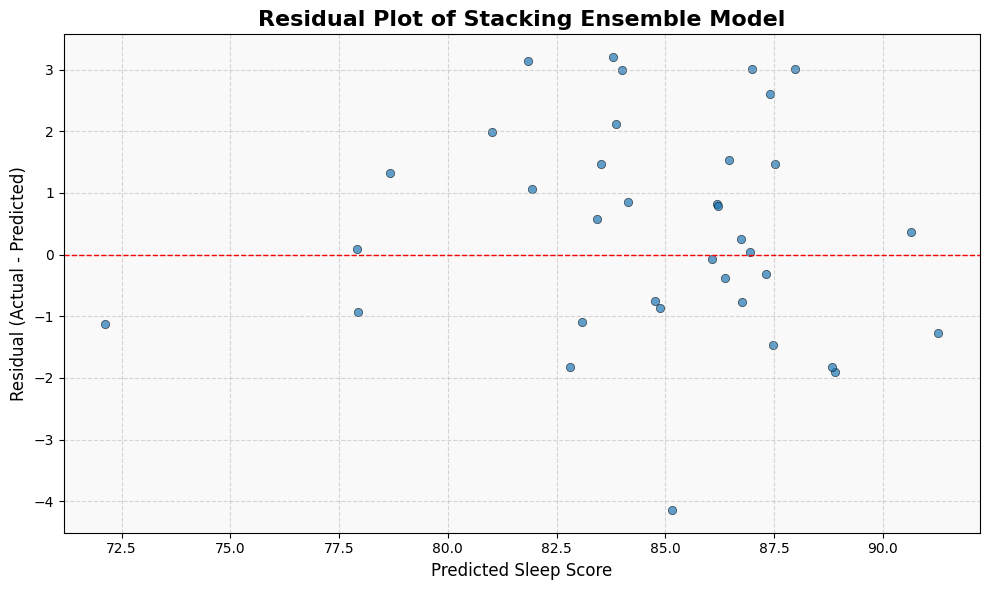

In [473]:
plt.figure(figsize=(10, 6))
# Residuals
residuals = y_test - y_pred_stack
# Scatterplot
sns.scatterplot(x=y_pred_stack, y=residuals, color="#1f77b4", edgecolor='black', alpha=0.7)
# Horizontal line at zero
plt.axhline(0, color='red', linestyle='--', linewidth=1)
# Titles and labels
plt.title("Residual Plot of Stacking Ensemble Model", fontsize=16, weight='bold')
plt.xlabel("Predicted Sleep Score", fontsize=12)
plt.ylabel("Residual (Actual - Predicted)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
# Add light background
plt.gca().set_facecolor("#f9f9f9")
plt.tight_layout()
plt.show()

The residual plot above shows the difference between the actual and predicted sleep scores (residuals) on the vertical axis, plotted against the predicted sleep scores on the horizontal axis.

Centering around zero:
Most residuals are clustered around 0, which indicates that the model is generally making accurate predictions. This is what we want—no consistent over- or under-prediction.

Symmetry and spread:
The residuals appear to be fairly symmetric and randomly scattered, without any clear pattern or curve. This suggests that the model is not missing a key nonlinear relationship and that the assumptions of linearity and independence are reasonably met.

Outliers:
There are a few larger residuals (e.g., one around -4), meaning the model underestimated sleep score by about 4 points in that instance. However, there are no extreme clusters or problematic trends, so these are likely just natural variance in the data.

No heteroscedasticity:
The spread of residuals is fairly constant across the range of predicted sleep scores. If we saw a funnel shape (widening or narrowing), it would suggest that the model struggles more in certain prediction ranges.